# 0. Setup

In [3]:
# imports
import pandas as pd

# library settings
pd.set_option('display.width', 1000)  # Set the display width
pd.set_option('display.max_columns', None)  # Display all columns


# 1. Cleaning


In [4]:
# Load
data_file = '../sensor_data_47.csv'
df = pd.read_csv(data_file)

# Inspection
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6440 entries, 0 to 6439
Data columns (total 22 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   timestamp                                                        6440 non-null   object 
 1   home47_bathroom652_sensor1198_room_light                         6438 non-null   float64
 2   home47_bathroom652_sensor1199_room_humidity                      6438 non-null   float64
 3   home47_bathroom652_sensor1200_room_temperature                   6438 non-null   float64
 4   home47_bedroom653_sensor1203_room_light                          6402 non-null   float64
 5   home47_bedroom653_sensor1204_room_humidity                       6399 non-null   float64
 6   home47_bedroom653_sensor1205_room_temperature                    6399 non-null   float64
 7   home47_hall654_sensor1208_room_light      

,timestamp,home47_bathroom652_sensor1198_room_light,home47_bathroom652_sensor1199_room_humidity,home47_bathroom652_sensor1200_room_temperature,home47_bedroom653_sensor1203_room_light,home47_bedroom653_sensor1204_room_humidity,home47_bedroom653_sensor1205_room_temperature,home47_hall654_sensor1208_room_light,home47_hall654_sensor1209_room_humidity,home47_hall654_sensor1210_room_temperature,home47_hall654_sensor1216c1220_electric-mains_electric-combined,home47_hall654_sensor1221_gas-pulse_gas,home47_kitchen650_sensor1174_room_light,home47_kitchen650_sensor1175_room_humidity,home47_kitchen650_sensor1176_room_temperature,home47_kitchen650_sensor1182_tempprobe_hot-water-cold-pipe,home47_kitchen650_sensor1183_tempprobe_hot-water-hot-pipe,home47_kitchen650_sensor1189_tempprobe_central-heating-return,home47_kitchen650_sensor1190_tempprobe_central-heating-flow,home47_livingroom651_sensor1193_room_light,home47_livingroom651_sensor1194_room_humidity,home47_livingroom651_sensor1195_room_temperature
0,2016-08-10 09:00:00,178.0,446.0,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.0,415.0,231.0,216.0,355.0,263.0,271.0,199.0,419.0,232.0
1,2016-08-10 10:00:00,95.0,468.0,228.0,103.0,481.0,205.0,24.0,468.0,216.0,242.0,NaN,139.0,451.0,218.0,207.0,347.0,263.0,281.0,81.0,446.0,220.0
2,2016-08-10 11:00:00,1.0,553.0,211.0,71.0,532.0,199.0,14.0,512.0,210.0,330.0,NaN,92.0,521.0,219.0,217.0,351.0,290.0,292.0,62.0,494.0,217.0
3,2016-08-10 12:00:00,3.0,573.0,207.0,72.0,557.0,199.0,14.0,532.0,207.0,169.0,NaN,84.0,512.0,219.0,219.0,295.0,252.0,257.0,56.0,508.0,215.0
4,2016-08-10 13:00:00,1.0,556.0,204.0,67.0,552.0,200.0,13.0,532.0,204.0,63.0,NaN,81.0,505.0,216.0,225.0,239.0,234.0,234.0,52.0,510.0,212.0


In [5]:
def rename_columns_simplified(column_name):
    parts = column_name.split('_')
    if len(parts) > 1:
        room = parts[1][:3]
        sensor_map = {
            'light': 'light',
            'humidity': 'humid',
            'temperature': 'temp',
            'hot-water-cold-pipe': 'coldpipe',
            'hot-water-hot-pipe': 'hotpipe',
            'central-heating-return': 'chreturn',
            'central-heating-flow': 'chflow',
            'electric-combined': 'elec',
            'gas': 'gas'
        }
        sensor = sensor_map.get(parts[-1], parts[-1])  # Map sensor name to simplified form
        return f"{room}_{sensor}"
    return column_name

# Apply updated renaming
df.rename(columns={col: rename_columns_simplified(col) for col in df.columns}, inplace=True)
for column in df.columns:
    print(column)

timestamp
bat_light
bat_humid
bat_temp
bed_light
bed_humid
bed_temp
hal_light
hal_humid
hal_temp
hal_elec
hal_gas
kit_light
kit_humid
kit_temp
kit_coldpipe
kit_hotpipe
kit_chreturn
kit_chflow
liv_light
liv_humid
liv_temp


In [6]:
# Inspect missing vals
missing_values = df.isnull().sum()
print(missing_values.sort_values(ascending=False))


hal_gas         4303
kit_chreturn    1841
kit_humid        130
kit_temp         130
kit_light        129
bed_humid         41
bed_temp          41
bed_light         38
hal_elec           9
kit_coldpipe       9
kit_hotpipe        9
kit_chflow         5
bat_light          2
bat_temp           2
bat_humid          2
hal_humid          1
hal_temp           1
hal_light          1
liv_humid          1
liv_light          1
liv_temp           1
timestamp          0
dtype: int64


In [7]:
# Imputation

## Electricity > linear interpolation, then bfill for 1st val
df['hal_elec'] = df['hal_elec'].interpolate(method='linear', limit_direction='forward')
df['hal_elec'] = df['hal_elec'].bfill()

## Gas > zeros
df['hal_gas'] = df['hal_gas'].fillna(0)

print(df[['hal_elec', 'hal_gas']].isnull().sum())


hal_elec    0
hal_gas     0
dtype: int64


# 2. EDA / Feature Engineering

             timestamp      elec  gas
0  2016-08-10 09:00:00  0.067223  0.0
1  2016-08-10 10:00:00  0.067223  0.0
2  2016-08-10 11:00:00  0.091667  0.0
3  2016-08-10 12:00:00  0.046945  0.0
4  2016-08-10 13:00:00  0.017500  0.0


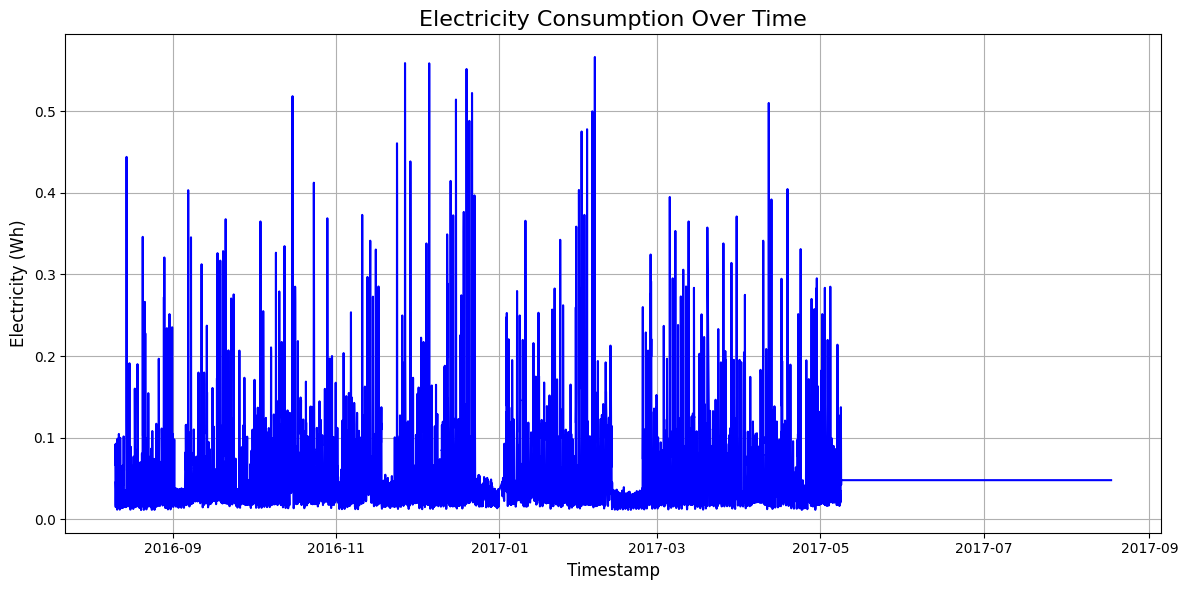

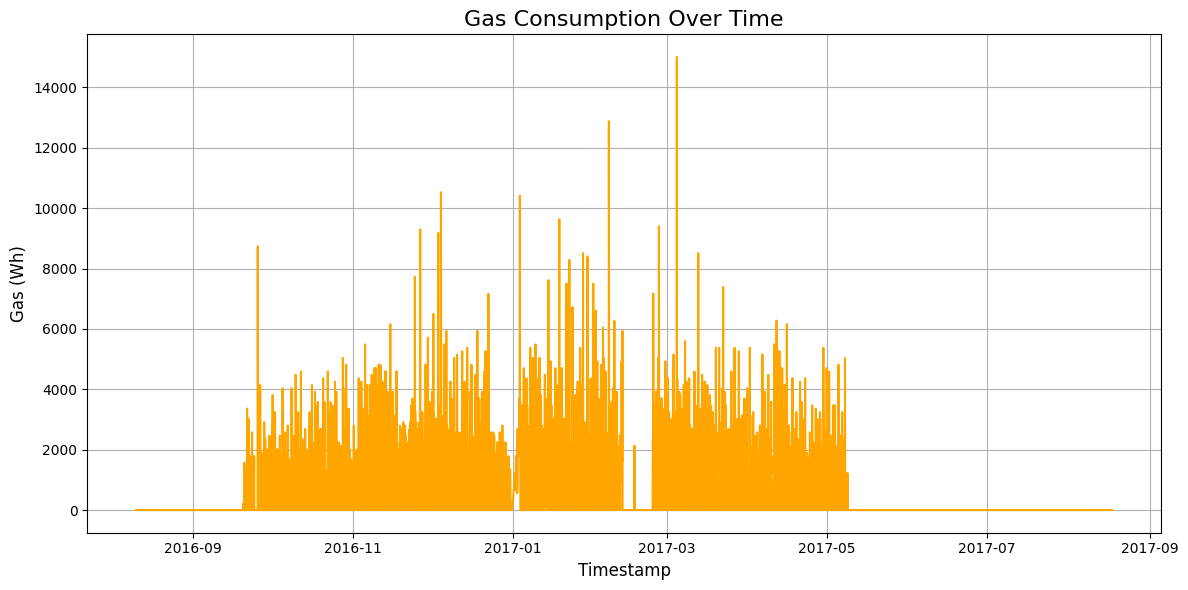

In [8]:
# Convert electricity to watt-hours (Wh) and sum
df['elec'] = df['hal_elec'] * 0.00027778  # Conversion factor from joules to Wh

# Sum gas data (already in Wh)
df['gas'] = df['hal_gas']

df = df[['timestamp', 'elec', 'gas']]
print(df.head())

# EDA
import matplotlib.pyplot as plt

# Convert timestamp to datetime for accurate plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot electricity time series
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['elec'], label='Electricity (Wh)', color='blue')
plt.title('Electricity Consumption Over Time', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Electricity (Wh)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot gas time series
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['gas'], label='Gas (Wh)', color='orange')
plt.title('Gas Consumption Over Time', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Gas (Wh)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. Basic ARIMA

In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test for stationarity
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)  # Set timestamp as index
check_stationarity(df['elec'])


ADF Statistic: -9.787596748646765
p-value: 6.480870253011363e-17
The series is stationary.


                               SARIMAX Results                                
Dep. Variable:                   elec   No. Observations:                 6440
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10543.419
Date:                Tue, 03 Dec 2024   AIC                         -21078.838
Time:                        17:57:09   BIC                         -21051.757
Sample:                    08-10-2016   HQIC                        -21069.467
                         - 05-05-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0511      0.002     21.484      0.000       0.046       0.056
ar.L1          0.5716      0.016     35.678      0.000       0.540       0.603
ma.L1         -0.0457      0.018     -2.565      0.0

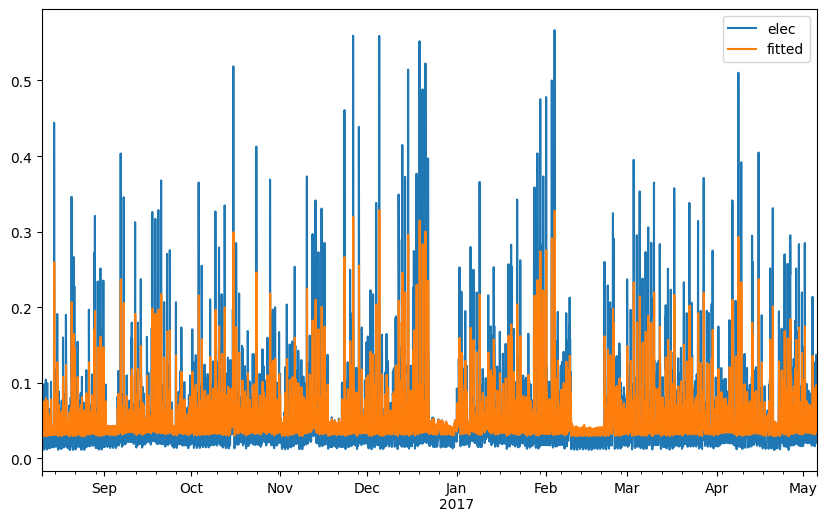

In [10]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit model
df.index = pd.date_range(start=df.index.min(), periods=len(df), freq='h')
model = ARIMA(df['elec'], order=(1, 0, 1))
fitted_model = model.fit()
print(fitted_model.summary())

# Plot the model's fitted values against the actual values
df['fitted'] = fitted_model.fittedvalues
df[['elec', 'fitted']].plot(figsize=(10, 6))
plt.show()

Normalized RMSE: 0.9203973876940332


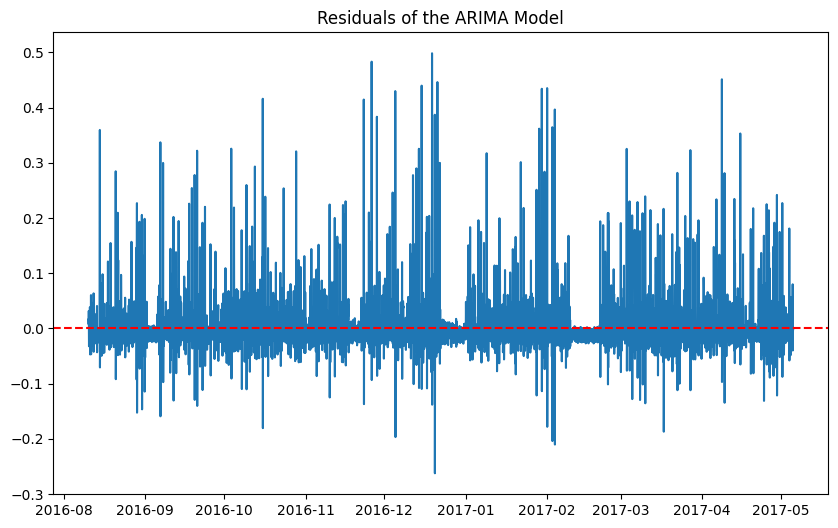

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate Normalised RMSE for the ARIMA model
rmse = np.sqrt(mean_squared_error(df['elec'], df['fitted']))
mean_elec = df['elec'].mean()
nrmse = rmse / mean_elec
print("Normalized RMSE:", nrmse)

# Plot residuals
residuals = df['elec'] - df['fitted']
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.axhline(0, color='red', linestyle='--')
plt.show()